In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [183]:
class BayesianLayer(nn.Module):
    def __init__(self,in_features,out_features,use_bias=True):
        super(BayesianLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = use_bias


        '''
        self.mu = nn.Parameter(torch.zeros(in_features, out_features).uniform_(-0.6, 0.6))
        self.rho = nn.Parameter(torch.zeros(in_features, out_features).uniform_(-6,-6))

        if self.use_bias:
            self.bias_mu = nn.Parameter(torch.zeros(out_features).uniform_(-0.6, 0.6))
            self.bias_rho = nn.Parameter(torch.zeros(out_features).uniform_(-6,-6)) '''

        self.mu = nn.Parameter(torch.normal(0.0, 1.0, (in_features, out_features)))
        self.rho = nn.Parameter(torch.zeros(self.in_features,self.out_features)-3)

        if self.use_bias:
            self.bias_mu = nn.Parameter(torch.normal(0.0, 1.0, (1, out_features)))
            self.bias_rho = nn.Parameter(torch.zeros(self.out_features)-3)
        
    
    def forward(self,x):
        epsilon = torch.normal(mean = 0.0, std = 1.0, size = self.mu.shape)
        
        w = self.mu + F.softplus(self.rho) * epsilon

        if self.use_bias:
            bias_epsilon = torch.normal(mean = 0.0, std = 1.0, size = self.bias_mu.shape)

            b = self.bias_mu + F.softplus(self.bias_rho) * bias_epsilon
        
        if self.use_bias:
            return torch.matmul(x,w) + b
        else:
            return torch.matmul(x,w)

        
    # total kl loss for the weights in this layer
    def compute_layer_kl_loss(self):
        layer_kl_loss = torch.sum(self._kl_loss(self.mu,self.rho))

        if self.use_bias:
            layer_kl_loss += torch.sum(self._kl_loss(self.bias_mu,self.bias_rho)) 

        return layer_kl_loss
    
    # kl loss between one weight's posterior and unit Gaussian prior (closed form complexity cost)
    def _kl_loss(self,temp_mu,temp_rho):
        sigma_squared = F.softplus(temp_rho) ** 2

        return -0.5 * (1 + torch.log(sigma_squared) - temp_mu ** 2 - sigma_squared)

        

class BayesianNet(nn.Module):
    def __init__(self, input_size,layer_width, output_size): # input size, num layers, layer_width
        super(BayesianNet, self).__init__()

        layers = []
        layers.append(BayesianLayer(input_size,layer_width))
        layers.append(nn.ReLU())
        layers.append(BayesianLayer(layer_width,layer_width))
        layers.append(nn.ReLU())
        layers.append(BayesianLayer(layer_width,output_size))

        self.net = nn.Sequential(*layers)


    def forward(self,x):
        return self.net(x)

    def compute_total_kl_loss(self):
        total_kl_loss = 0

        for i in self.children():  
            for j in i.children():
                if isinstance(j,BayesianLayer):
                    total_kl_loss += j.compute_layer_kl_loss()
        return total_kl_loss
    


In [3]:
class MLP(nn.Module):
    def __init__(self, input_size,layer_width, output_size): # input size, num layers, layer_width
        super(MLP, self).__init__()

        layers = []
        layers.append(nn.Linear(input_size,layer_width))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_width,output_size))

        self.net = nn.Sequential(*layers)
        
    def forward(self,x):
        return self.net(x)

In [140]:
x = torch.arange(start=0.0,end=0.5,step=0.01)
y = torch.Tensor([])

for temp_x in x:
    eps = torch.normal(torch.Tensor([0]),torch.Tensor([0.02]))
    temp_y = (temp_x + 0.3 * torch.sin(2*torch.Tensor([np.pi])*(temp_x + eps)) + 0.3 * torch.sin(4 * torch.Tensor([np.pi]) *(temp_x + eps)) + eps)
    y = torch.cat((y,temp_y))

x = torch.unsqueeze(x,dim=1)
y = torch.unsqueeze(y,dim=1)

In [213]:
model = BayesianNet(1,16,1)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()


for e in range(10001):

    optimizer.zero_grad()

    y_pred = model(x)

    #KL term encourages q to be more spread out (i.e. more stochasticity in the weights).
    loss = criterion(y_pred, y) + 1e-4 * model.compute_total_kl_loss()
    
    if e%1000==0:
        print(f'epoch: {e}, loss: {loss.item():.4f}')


    loss.backward()

    optimizer.step()



epoch: 0, loss: 29.2171
epoch: 1000, loss: 0.0594
epoch: 2000, loss: 0.0653
epoch: 3000, loss: 0.0503
epoch: 4000, loss: 0.0421
epoch: 5000, loss: 0.0443
epoch: 6000, loss: 0.0367
epoch: 7000, loss: 0.0341
epoch: 8000, loss: 0.0345
epoch: 9000, loss: 0.0253
epoch: 10000, loss: 0.0214


100%|██████████| 50/50 [00:00<00:00, 2173.82it/s]


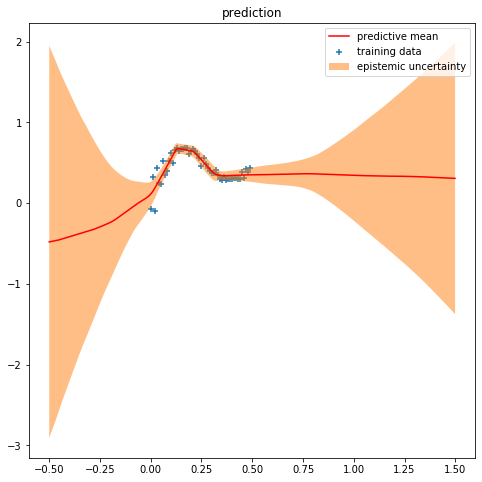

In [214]:
x_test = torch.arange(start=-0.5,end=1.5,step=0.001)
x_test = torch.unsqueeze(x_test,dim=1)

y_pred_list = []

for i in tqdm.tqdm(range(50)):
    y_pred = model(x_test).detach().numpy()
    y_pred_list.append(y_pred)


y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

figure(figsize=(8,8))
plt.plot(x_test, y_mean, 'r-', label='predictive mean');
plt.scatter(x, y, marker='+', label='training data')
plt.fill_between(x_test.numpy().ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='epistemic uncertainty')
plt.title('prediction')
plt.legend()